Wed Jul 2nd 2025,
Jakob Balkovec

This serves as a follow up to the report from `0_02_algorithm_for_patch_exteaction.ipynb`. Here I took a look at the results from the algorithm.

In [3]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt


## Parsing the Results

### Config

In [15]:
DIR = "../data/algorithm_output"

FILES = [
    "area.json",
    "area_weights_1.json",
    "area_weights_2.json",
    "area_weights_3.json",
    "area_weights_DBSCAN_1.json",
    "area_weights_DBSCAN_2.json",
    "area_weights_DBSCAN_3.json"
]


### Reading the Data

In [20]:
def load_json_logs(json_dir, filenames):
    all_data = {}
    for fname in filenames:
        full_path = os.path.join(json_dir, fname)
        try:
            with open(full_path, "r") as f:
                data = json.load(f)
                if isinstance(data, list):
                    all_data[fname.replace(".json", "")] = data
                else:
                    all_data[fname.replace(".json", "")] = [data]
        except json.JSONDecodeError:
            print(f"Could not parse {fname}")
            all_data[fname.replace(".json", "")] = []
    return all_data

# call
all_data = load_json_logs(DIR, FILES)


### Compression

In [37]:
def build_comparison_dataframe(all_data):
    rows = []
    for method, entries in all_data.items():
        for entry in entries:
            candidates = entry.get("candidates", {})
            picked = entry.get("picked")

            if isinstance(picked, dict):
                picked_label = list(picked.keys())[0]
                picked_score = picked[picked_label]
            else:
                picked_label = picked
                picked_score = candidates.get(picked_label, None)

            rows.append({
                "method": method,
                "picked_label": picked_label,
                "picked_score": picked_score,
                "num_candidates": len(candidates),
                "total_score": sum(candidates.values())
            })
    return pd.DataFrame(rows)

# call
comparison_df = build_comparison_dataframe(all_data)
comparison_df["patch_id"] = comparison_df.groupby("method").cumcount()


### Plot Functions

In [28]:
def plot_label_distribution(df):
    label_dist = df.groupby(["method", "picked_label"]).size().unstack(fill_value=0)
    label_dist.plot(kind="bar", stacked=True, figsize=(12, 6))
    plt.title("Picked Lesion Label Distribution by Method")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

def plot_avg_total_score(df):
    df.groupby("method")["total_score"].mean().sort_values().plot(kind="bar", figsize=(10, 4))
    plt.title("Average Total Candidate Score per Patch")
    plt.ylabel("Avg Total Score")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

def plot_label_diversity(df):
    diversity = df.groupby("method")["picked_label"].nunique().sort_values()
    diversity.plot(kind="bar", figsize=(10, 4))
    plt.title("Number of Unique Labels Picked per Method")
    plt.ylabel("Unique Picked Labels")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

def plot_score_distribution_boxplot(df):
    df = df.copy()
    df["picked_pct"] = df["picked_score"] / df["total_score"]
    plt.figure(figsize=(12, 6))
    df.boxplot(column="picked_pct", by="method", grid=False)
    plt.title("Distribution of Picked Score % per Method")
    plt.suptitle("")
    plt.ylabel("Picked Score / Total Score")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


## Results

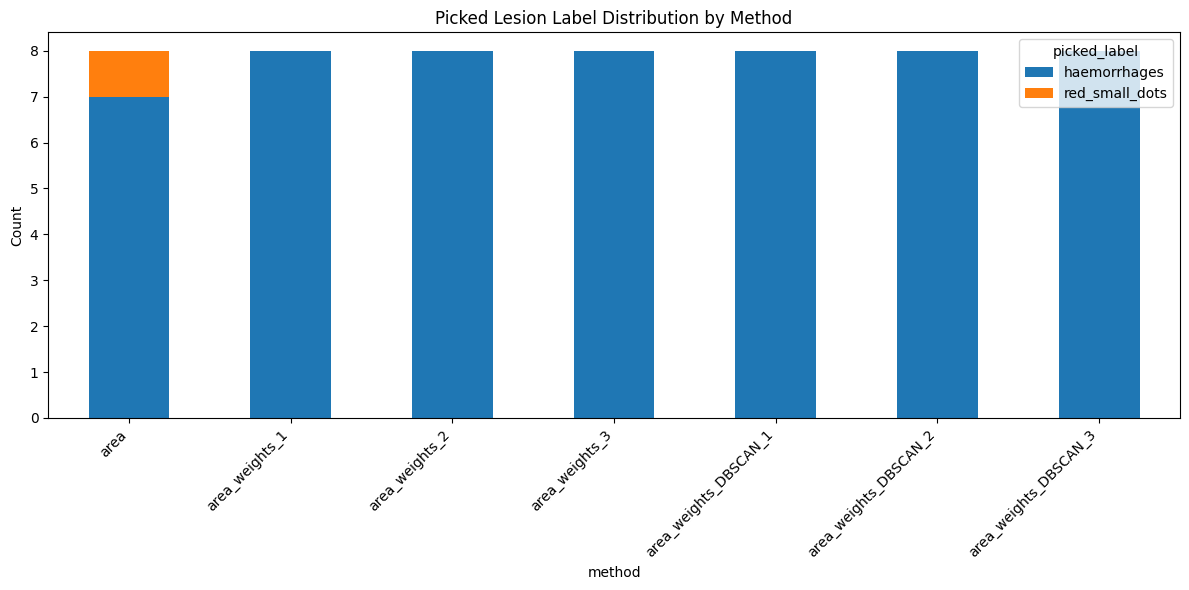

In [23]:
plot_label_distribution(comparison_df)


The Area based approach was the only one that picked `red_small_dots` over hemorrhages.

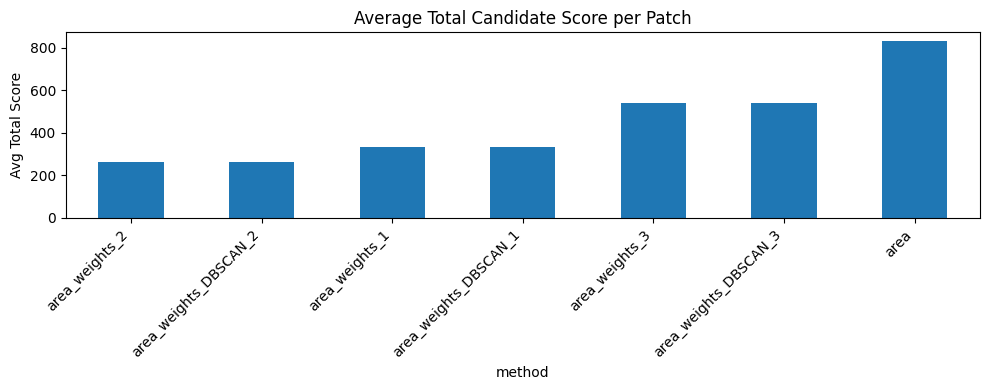

In [25]:
plot_avg_total_score(comparison_df)


This visualizes how weights and DBSCAN influence the final score. `MAP #2` dominates here since it's risk based. I think this is worth discussing on Monday.

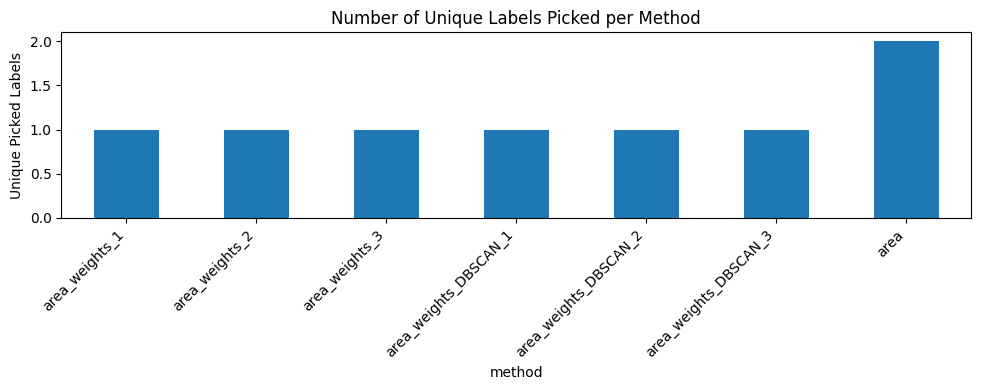

In [30]:
plot_label_diversity(comparison_df)


This is self explanatory. It's only here because I'll be running the same script with different images and hopefully get different results.

<Figure size 1200x600 with 0 Axes>

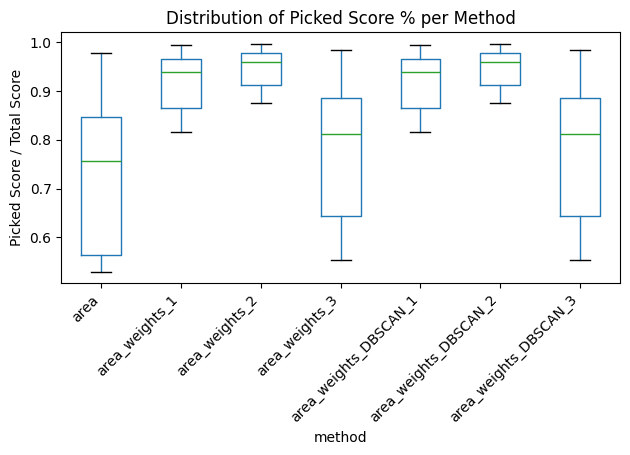

In [31]:
plot_score_distribution_boxplot(comparison_df)


In [38]:
def compute_method_agreement(df):
    df_unique = df.drop_duplicates(subset=["patch_id", "method"])
    pivot = df_unique.pivot_table(index="patch_id", columns="method", values="picked_label", aggfunc="first")

    pivot["agreement_count"] = pivot.nunique(axis=1)
    total_patches = len(pivot)
    full_agreement = (pivot["agreement_count"] == 1).sum()

    print(f"Total patches: {total_patches}")
    print(f"Full agreement (same label across all methods): {full_agreement} patches")
    print(f"Agreement rate: {full_agreement / total_patches:.2%}")

    return pivot

pivot_df = compute_method_agreement(comparison_df)
disagreements = pivot_df[pivot_df["agreement_count"] > 1]


Total patches: 8
Full agreement (same label across all methods): 7 patches
Agreement rate: 87.50%


In [39]:
def flag_unique_dominance(pivot_df):
    unique_methods = []

    for idx, row in pivot_df.drop(columns="agreement_count").iterrows():
        label_counts = row.value_counts()
        if label_counts.max() == 1:
            unique_methods.append((idx, row.to_dict()))

    print(f"Unique dominance in {len(unique_methods)} patches (i.e., each method picked a different label)")

    return pd.DataFrame([{"source_img": idx[0], "patch_no": idx[1], **labels}
                         for idx, labels in unique_methods])

unique_df = flag_unique_dominance(pivot_df)


Unique dominance in 0 patches (i.e., each method picked a different label)


In [26]:
# comparison_df.to_csv("comparison_summary.csv", index=False)
